# Pix2Pix pour la Traduction SAR vers Optique : Suppression de Nuages

**Projet M2 Géomatique**  
**Objectif** : Développer un modèle GAN conditionnel pour générer des images optiques claires à partir d'images SAR et d'images optiques nuageuses.

## Contexte Scientifique

Les images satellites optiques (Sentinel-2) sont fréquemment perturbées par la couverture nuageuse, limitant leur disponibilité pour l'observation terrestre. Les images radar SAR (Sentinel-1), acquises par temps nuageux, offrent une continuité temporelle mais avec une interprétation complexe. L'objectif de ce projet est de fusionner ces deux sources pour reconstruire des images optiques claires.

### Architecture Proposée

**Modèle** : Pix2Pix (Isola et al., 2017)  
**Générateur** : U-Net (5 canaux → 3 canaux)  
**Discriminateur** : PatchGAN (70×70 patches)  
**Dataset** : SEN12 Multisaison (Summer + Winter, ~8000 triplets)

### Entrées et Sorties

**Entrée** : Tenseur 5 canaux (5, 256, 256)
- Canal 0-1 : Sentinel-1 VV et VH (SAR)
- Canal 2-4 : Sentinel-2 RGB nuageux

**Sortie** : Tenseur 3 canaux (3, 256, 256)
- Sentinel-2 RGB clair (reconstruction)

---

## 1. Préparation du Dataset : Nettoyage et Validation

**Étape préalable OBLIGATOIRE** : Avant d'utiliser ce notebook, le dataset doit être nettoyé et validé.

### Pourquoi nettoyer le dataset ?

Le dataset SEN12 brut contient des images corrompues ou sans contenu significatif :
- Images SAR vides (océans, corruption)
- Images optiques plates (couverture nuageuse totale)
- Fichiers mal formés

Le script `clean_dataset.py` filtre automatiquement ces cas en appliquant des critères de validation :
- **SAR** : écart-type > 0.0001 et valeur max > 0.001
- **Optique** : écart-type moyen RGB > 10.0

### Génération du CSV validé

**Option 1 : Exécution depuis le terminal** (Recommandé)
```bash
python clean_dataset.py
```

**Option 2 : Exécution depuis ce notebook**
Décommentez et exécutez la cellule suivante pour lancer le nettoyage.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
import importlib

# Configuration matplotlib pour affichage scientifique
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# Chemins du projet
DATA_ROOT = Path("data/sen_1_2")
CSV_FILE = DATA_ROOT / "cleaned_triplets.csv"

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3080


In [2]:
# DÉCOMMENTER POUR LANCER LE NETTOYAGE DU DATASET
# Cela peut prendre 10-20 minutes selon la taille du dataset

# import subprocess
# result = subprocess.run(['python', 'clean_dataset.py'], capture_output=True, text=True)
# print(result.stdout)
# if result.returncode != 0:
#     print("ERREUR:", result.stderr)

# OU vérifier si le CSV existe déjà
from pathlib import Path
CSV_PATH = Path("data/sen_1_2/cleaned_triplets.csv")
if CSV_PATH.exists():
    print("✓ Le fichier cleaned_triplets.csv existe déjà.")
    print("  Vous pouvez continuer avec le reste du notebook.")
else:
    print("✗ Le fichier cleaned_triplets.csv n'existe pas encore.")
    print("  Exécutez d'abord : python clean_dataset.py")
    print("  Ou décommentez les lignes ci-dessus pour lancer le nettoyage.")

✓ Le fichier cleaned_triplets.csv existe déjà.
  Vous pouvez continuer avec le reste du notebook.


## 2. Dataset SEN12 : Structure et Statistiques

Le dataset SEN12 contient des triplets géo-référencés de patches 256×256 pixels :
- **S1** : Image SAR Sentinel-1 (2 canaux VV/VH)
- **S2** : Image optique claire Sentinel-2 (13 bandes spectrales)
- **S2 Cloudy** : Même scène avec couverture nuageuse

### 2.1 Analyse de la Structure

In [3]:
# Charger les statistiques du dataset nettoyé
if CSV_FILE.exists():
    df = pd.read_csv(CSV_FILE)
    print(f"Dataset nettoyé : {len(df)} triplets validés")
    print(f"\nColonnes du CSV :")
    print(df.columns.tolist())
    
    # Statistiques par saison
    if 'id' in df.columns:
        seasons = {}
        for patch_id in df['id']:
            season = str(patch_id).split('_')[0]
            seasons[season] = seasons.get(season, 0) + 1
        
        print(f"\nRépartition par saison :")
        for season, count in sorted(seasons.items()):
            print(f"  - {season.capitalize()} : {count} triplets ({count/len(df)*100:.1f}%)")
    
    print(f"\nExemple de triplets :")
    print(df.head())
else:
    print(f"✗ ERREUR : Fichier {CSV_FILE} introuvable.")
    print("  Vous devez d'abord générer le CSV validé.")
    print("  Retournez à la section 1.1 et exécutez : python clean_dataset.py")

Dataset nettoyé : 4464 triplets validés

Colonnes du CSV :
['id', 's1_root_folder', 's1_folder', 's1_file', 's2_root_folder', 's2_folder', 's2_file', 's2_cloudy_root_folder', 's2_cloudy_folder', 's2_cloudy_file']

Répartition par saison :
  - Summer : 4069 triplets (91.2%)
  - Winter : 395 triplets (8.8%)

Exemple de triplets :
                id      s1_root_folder s1_folder  \
0  summer_114_p100  ROIs1868_summer_s1    s1_114   
1  summer_114_p101  ROIs1868_summer_s1    s1_114   
2  summer_114_p102  ROIs1868_summer_s1    s1_114   
3  summer_114_p117  ROIs1868_summer_s1    s1_114   
4  summer_114_p118  ROIs1868_summer_s1    s1_114   

                           s1_file      s2_root_folder s2_folder  \
0  ROIs1868_summer_s1_114_p100.tif  ROIs1868_summer_s2    s2_114   
1  ROIs1868_summer_s1_114_p101.tif  ROIs1868_summer_s2    s2_114   
2  ROIs1868_summer_s1_114_p102.tif  ROIs1868_summer_s2    s2_114   
3  ROIs1868_summer_s1_114_p117.tif  ROIs1868_summer_s2    s2_114   
4  ROIs1868_summe

## 2.2 Vérification des Dimensions et Types

In [5]:
# Charger un exemple pour vérifier la structure
if CSV_FILE.exists() and len(df) > 0:
    example = df.iloc[0]
    
    # Support nouveau format (10 colonnes avec root_folders) et ancien format (7 colonnes)
    s1_root = example.get('s1_root_folder', 'ROIs1868_summer_s1')
    s2_root = example.get('s2_root_folder', 'ROIs1868_summer_s2')
    s2_cloudy_root = example.get('s2_cloudy_root_folder', 'ROIs1868_summer_s2_cloudy')
    
    s1_path = DATA_ROOT / s1_root / example['s1_folder'] / example['s1_file']
    s2_path = DATA_ROOT / s2_root / example['s2_folder'] / example['s2_file']
    s2_cloudy_path = DATA_ROOT / s2_cloudy_root / example['s2_cloudy_folder'] / example['s2_cloudy_file']
    
    print(f"Patch ID : {example['id']}")
    if 's1_root_folder' in example:
        print(f"Saison   : {example['id'].split('_')[0].capitalize()}\n")
    
    with rasterio.open(s1_path) as src:
        print(f"Sentinel-1 (SAR)")
        print(f"  Bandes        : {src.count} (VV, VH)")
        print(f"  Dimensions    : {src.width} × {src.height} pixels")
        print(f"  Type          : {src.dtypes[0]}")
        print(f"  Résolution    : {src.res[0]:.2f} m\n")
    
    with rasterio.open(s2_path) as src:
        print(f"Sentinel-2 (Optique)")
        print(f"  Bandes        : {src.count}")
        print(f"  Dimensions    : {src.width} × {src.height} pixels")
        print(f"  Type          : {src.dtypes[0]}")
        print(f"  Résolution    : {src.res[0]:.2f} m")

Patch ID : summer_114_p100
Saison   : Summer

Sentinel-1 (SAR)
  Bandes        : 2 (VV, VH)
  Dimensions    : 256 × 256 pixels
  Type          : float32
  Résolution    : 10.00 m

Sentinel-2 (Optique)
  Bandes        : 13
  Dimensions    : 256 × 256 pixels
  Type          : uint16
  Résolution    : 10.00 m


## 3. Normalisation des Données

### 3.1 Normalisation SAR : Conversion en dB et Clipping Adapté par Polarisation

**Problématique** : La rétrodiffusion SAR présente une plage dynamique très étendue (facteur 10⁵), rendant difficile l'apprentissage par des réseaux de neurones. De plus, VV et VH ont des ranges physiques différents.

**Solution appliquée** :
1. Conversion en échelle logarithmique (dB) : $\text{dB} = 10 \log_{10}(\sigma^0 + \epsilon)$
2. Clipping adapté par polarisation (VV et VH ont des ranges différents)
3. Normalisation linéaire vers [-1, 1] pour compatibilité avec activation tanh

**Justification des ranges par polarisation** :
- **VV (co-pol)** : [-25, 0] dB
  - Surfaces réfléchissantes (bâtiments, végétation dense, sols humides)
  - Adapté pour été et hiver
  
- **VH (cross-pol)** : [-35, -5] dB
  - Rétrodiffusion plus faible (dépolarisation par végétation, rugosité sols)
  - Évite saturation à -1 qui rendait VH constant
  - Critique pour distinguer types de surfaces en multisaison

In [7]:
def normalize_sar_vv(data):
    """
    Normalise les données SAR VV (co-polarisation) vers [-1, 1].
    
    Détecte automatiquement si les données sont en dB ou en intensité linéaire.
    La détection repose sur l'analyse de la distribution des valeurs :
    - Si >80% des valeurs sont négatives ou dans [-40, 5] : déjà en dB
    - Sinon : intensité linéaire nécessitant conversion logarithmique
    
    Range typique VV: [-25, 0] dB
    Adapté pour été (végétation) et hiver (sols nus).
    
    Args:
        data (np.ndarray): Image SAR VV (dB ou intensité linéaire σ⁰)
    
    Returns:
        np.ndarray: Image normalisée dans [-1, 1]
    """
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Détection automatique du format
    if np.sum(data < 0) > 0.8 * data.size or (data.min() < 0 and data.max() < 10):
        db = data  # Déjà en dB
    else:
        data = np.maximum(data, 1e-6)
        db = 10 * np.log10(data)  # Conversion linéaire → dB
    
    db = np.clip(db, -25, 0)
    normalized = ((db + 25.0) / 25.0) * 2.0 - 1.0
    return normalized.astype(np.float32)

def normalize_sar_vh(data):
    """
    Normalise les données SAR VH (cross-polarisation) vers [-1, 1].
    
    Détecte automatiquement si les données sont en dB ou en intensité linéaire.
    
    Range typique VH: [-35, -5] dB (plus faible que VV)
    La cross-polarisation VH capture la dépolarisation par la végétation (été)
    et la rugosité de surface des sols nus (hiver). Le range plus faible reflète
    une rétrodiffusion intrinsèquement plus faible que la co-polarisation VV.
    
    Args:
        data (np.ndarray): Image SAR VH (dB ou intensité linéaire σ⁰)
    
    Returns:
        np.ndarray: Image normalisée dans [-1, 1]
    """
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Détection automatique du format
    if np.sum(data < 0) > 0.8 * data.size or (data.min() < 0 and data.max() < 10):
        db = data  # Déjà en dB
    else:
        data = np.maximum(data, 1e-6)
        db = 10 * np.log10(data)  # Conversion linéaire → dB
    
    db = np.clip(db, -35, -5)
    normalized = ((db + 35.0) / 30.0) * 2.0 - 1.0
    return normalized.astype(np.float32)

print("Fonctions de normalisation SAR définies :")
print("  - normalize_sar_vv() : VV co-pol, range [-25, 0] dB")
print("  - normalize_sar_vh() : VH cross-pol, range [-35, -5] dB")
print("  - Auto-détection du format : dB ou intensité linéaire")
print("\nNormalisation adaptée pour multisaison (Summer + Winter)")

Fonctions de normalisation SAR définies :
  - normalize_sar_vv() : VV co-pol, range [-25, 0] dB
  - normalize_sar_vh() : VH cross-pol, range [-35, -5] dB
  - Auto-détection du format : dB ou intensité linéaire

Normalisation adaptée pour multisaison (Summer + Winter)


### 3.2 Normalisation Optique : Division Fixe

**Problématique** : Les images Sentinel-2 sont codées en uint16 (0-10000) avec des valeurs de réflectance variables.

**Solution** : Normalisation fixe par division par 3000 (valeur typique de réflectance pour scènes terrestres L1C/L2A).

**Avantage** : Préserve la cohérence colorimétrique entre images, contrairement à une normalisation min-max qui varie par image.

In [8]:
def normalize_optical(data):
    """
    Normalise les données optiques (Sentinel-2) vers [-1, 1].
    
    Utilise une division fixe par 3000 pour préserver la cohérence
    colorimétrique entre images.
    
    Args:
        data (np.ndarray): Bande spectrale Sentinel-2 (uint16)
    
    Returns:
        np.ndarray: Bande normalisée dans [-1, 1]
    """
    data = np.nan_to_num(data.astype(np.float32), nan=0.0)
    data = np.clip(data, 0, 3000)
    normalized = (data / 3000.0) * 2.0 - 1.0
    return normalized.astype(np.float32)

def denormalize_for_display(tensor):
    """
    Convertit un tenseur [-1, 1] vers [0, 1] pour affichage matplotlib.
    """
    return np.clip((tensor + 1.0) / 2.0, 0, 1)

print("Fonction normalize_optical() définie.")
print("Pipeline : uint16 → clip[0,3000] → ÷3000 → [-1,1]")

Fonction normalize_optical() définie.
Pipeline : uint16 → clip[0,3000] → ÷3000 → [-1,1]


## 4. Visualisation et Validation des Triplets de Données

### 4.1 Visualisation d'un Triplet Représentatif

Cette section charge et affiche un triplet (SAR, S2 Cloudy, S2 Clear) pour vérifier la correspondance géométrique entre images, l'effet de la normalisation appliquée et la présence effective de couverture nuageuse dans les données S2 Cloudy.

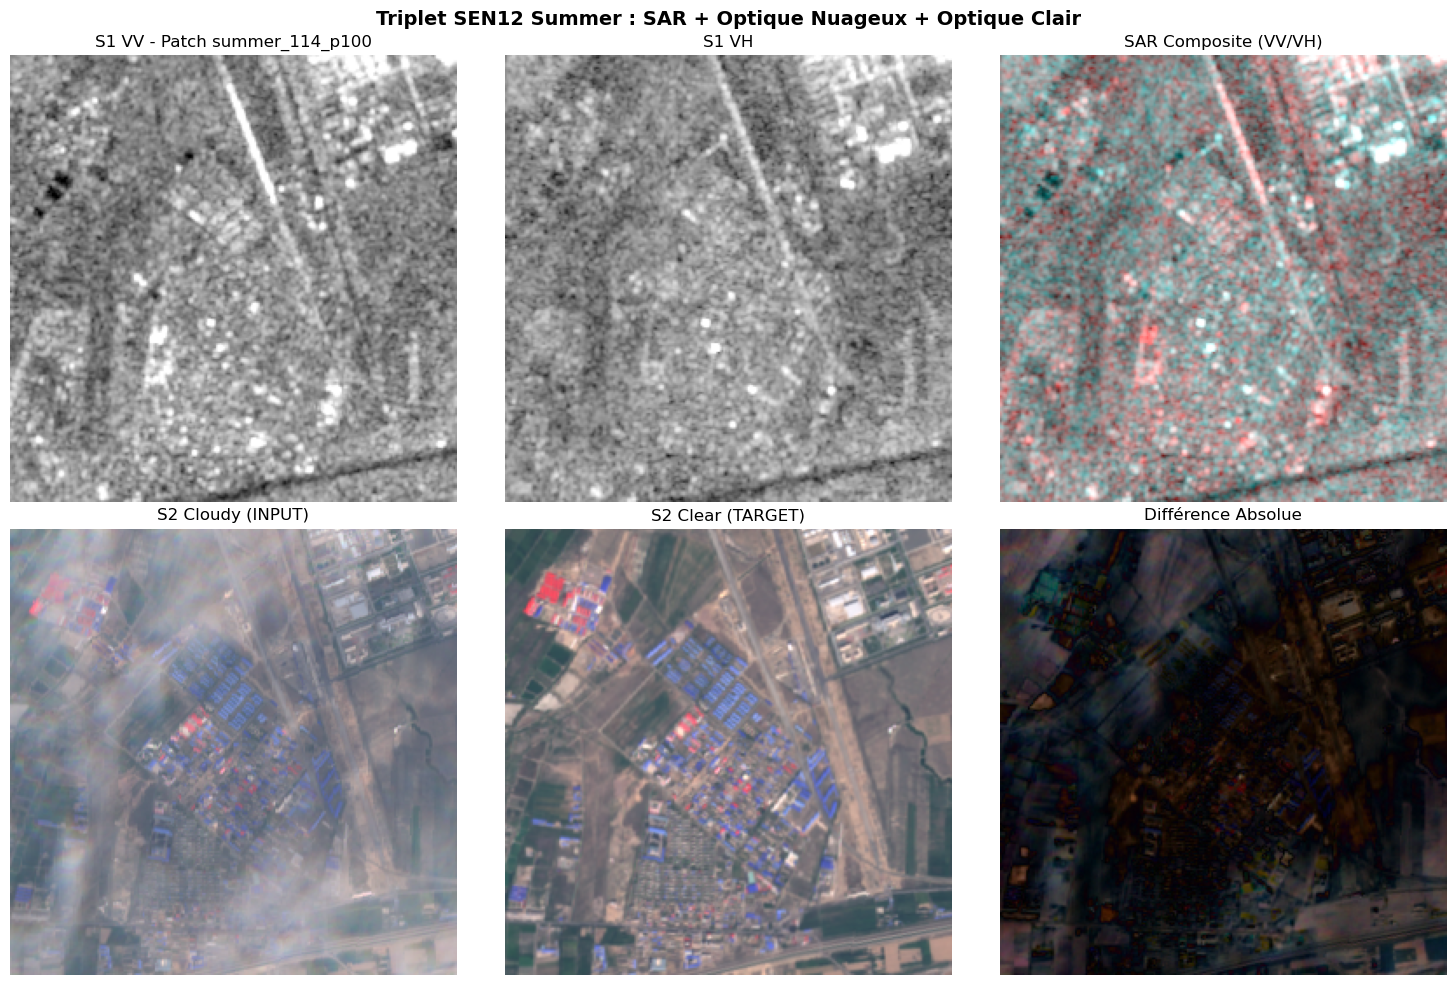


Statistiques de normalisation (Patch summer_114_p100) :
  VV normalisé    : min=-1.000, max=1.000, mean=0.158
  VH normalisé    : min=-0.852, max=1.000, mean=0.145
  S2 Cloudy RGB   : min=-0.439, max=1.000
  S2 Clear RGB    : min=-0.638, max=1.000

Validation :
  - Normalisation SAR différenciée par polarisation
  - Auto-détection du format (dB vs intensité linéaire)
  - Normalisation optique adaptée pour multisaison


In [9]:
if CSV_FILE.exists() and len(df) > 0:
    example = df.iloc[0]
    
    # Support multisaison
    s1_root = example.get('s1_root_folder', 'ROIs1868_summer_s1')
    s2_root = example.get('s2_root_folder', 'ROIs1868_summer_s2')
    s2_cloudy_root = example.get('s2_cloudy_root_folder', 'ROIs1868_summer_s2_cloudy')
    
    # Construire les chemins
    s1_path = DATA_ROOT / s1_root / example['s1_folder'] / example['s1_file']
    s2_path = DATA_ROOT / s2_root / example['s2_folder'] / example['s2_file']
    s2_cloudy_path = DATA_ROOT / s2_cloudy_root / example['s2_cloudy_folder'] / example['s2_cloudy_file']
    
    # Charger Sentinel-1 (2 bandes : VV, VH)
    with rasterio.open(s1_path) as src:
        vv_raw = src.read(1)
        vh_raw = src.read(2)
    
    # Appliquer les fonctions de normalisation distinctes par polarisation
    vv_norm = normalize_sar_vv(vv_raw)
    vh_norm = normalize_sar_vh(vh_raw)
    
    # Charger Sentinel-2 Cloudy (bandes B04, B03, B02 pour RGB)
    with rasterio.open(s2_cloudy_path) as src:
        bands_cloudy = src.read()
    
    r_cloudy = normalize_optical(bands_cloudy[3])  # B04 = Rouge
    g_cloudy = normalize_optical(bands_cloudy[2])  # B03 = Vert
    b_cloudy = normalize_optical(bands_cloudy[1])  # B02 = Bleu
    
    # Charger Sentinel-2 Clear
    with rasterio.open(s2_path) as src:
        bands_clear = src.read()
    
    r_clear = normalize_optical(bands_clear[3])
    g_clear = normalize_optical(bands_clear[2])
    b_clear = normalize_optical(bands_clear[1])
    
    # Créer composites RGB
    cloudy_rgb = np.stack([r_cloudy, g_cloudy, b_cloudy], axis=-1)
    clear_rgb = np.stack([r_clear, g_clear, b_clear], axis=-1)
    
    # Convertir pour affichage
    vv_display = denormalize_for_display(vv_norm)
    vh_display = denormalize_for_display(vh_norm)
    cloudy_display = denormalize_for_display(cloudy_rgb)
    clear_display = denormalize_for_display(clear_rgb)
    
    # Affichage
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    axes[0, 0].imshow(vv_display, cmap='gray', vmin=0, vmax=1)
    axes[0, 0].set_title(f'S1 VV - Patch {example["id"]}')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(vh_display, cmap='gray', vmin=0, vmax=1)
    axes[0, 1].set_title('S1 VH')
    axes[0, 1].axis('off')
    
    # Composite SAR (VV+VH pour visualisation)
    sar_composite = np.stack([vv_display, vh_display, vh_display], axis=-1)
    axes[0, 2].imshow(sar_composite)
    axes[0, 2].set_title('SAR Composite (VV/VH)')
    axes[0, 2].axis('off')
    
    axes[1, 0].imshow(cloudy_display)
    axes[1, 0].set_title('S2 Cloudy (INPUT)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(clear_display)
    axes[1, 1].set_title('S2 Clear (TARGET)')
    axes[1, 1].axis('off')
    
    # Différence (met en évidence les nuages)
    diff = np.abs(clear_display - cloudy_display)
    axes[1, 2].imshow(diff)
    axes[1, 2].set_title('Différence Absolue')
    axes[1, 2].axis('off')
    
    season = example['id'].split('_')[0].capitalize() if '_' in str(example['id']) else 'Summer'
    plt.suptitle(f"Triplet SEN12 {season} : SAR + Optique Nuageux + Optique Clair", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\nStatistiques de normalisation (Patch {example['id']}) :")
    print(f"  VV normalisé    : min={vv_norm.min():.3f}, max={vv_norm.max():.3f}, mean={vv_norm.mean():.3f}")
    print(f"  VH normalisé    : min={vh_norm.min():.3f}, max={vh_norm.max():.3f}, mean={vh_norm.mean():.3f}")
    print(f"  S2 Cloudy RGB   : min={cloudy_rgb.min():.3f}, max={cloudy_rgb.max():.3f}")
    print(f"  S2 Clear RGB    : min={clear_rgb.min():.3f}, max={clear_rgb.max():.3f}")
    print(f"\nValidation :")
    print(f"  - Normalisation SAR différenciée par polarisation")
    print(f"  - Auto-détection du format (dB vs intensité linéaire)")
    print(f"  - Normalisation optique adaptée pour multisaison")

### 4.2 Analyse Comparative Multisaison : Normalisation Optique

Cette section évalue l'adaptation de la stratégie de normalisation optique (division fixe par 3000) pour les données été et hiver. Les caractéristiques de réflectance Sentinel-2 varient significativement entre saisons en raison des changements de couverture végétale, d'humidité des sols et de présence potentielle de neige.

**Objectif** : Quantifier les distributions de réflectance par saison et identifier d'éventuels risques de saturation ou de sous-exposition.

In [10]:
# Analyse quantitative des statistiques optiques par saison
if CSV_FILE.exists() and len(df) > 0:
    print("Analyse des valeurs brutes Sentinel-2 par saison")
    print("="*70)
    
    # Séparer les triplets par saison
    summer_triplets = df[df['id'].str.startswith('summer')]
    winter_triplets = df[df['id'].str.startswith('winter')]
    
    print(f"\nDataset : {len(summer_triplets)} Summer, {len(winter_triplets)} Winter")
    
    def analyze_optical_sample(row, season_name):
        """Analyse les valeurs brutes d'un triplet optique"""
        s2_root = row.get('s2_root_folder', 'ROIs1868_summer_s2')
        s2_cloudy_root = row.get('s2_cloudy_root_folder', 'ROIs1868_summer_s2_cloudy')
        
        s2_path = DATA_ROOT / s2_root / row['s2_folder'] / row['s2_file']
        s2_cloudy_path = DATA_ROOT / s2_cloudy_root / row['s2_cloudy_folder'] / row['s2_cloudy_file']
        
        with rasterio.open(s2_path) as src:
            bands_clear = src.read([4, 3, 2])  # RGB: B04, B03, B02
        
        with rasterio.open(s2_cloudy_path) as src:
            bands_cloudy = src.read([4, 3, 2])
        
        clear_stats = {
            'min': bands_clear.min(),
            'max': bands_clear.max(),
            'mean': bands_clear.mean(),
            'std': bands_clear.std(),
            'p95': np.percentile(bands_clear, 95),
            'p99': np.percentile(bands_clear, 99),
            'data': bands_clear
        }
        
        cloudy_stats = {
            'min': bands_cloudy.min(),
            'max': bands_cloudy.max(),
            'mean': bands_cloudy.mean(),
            'std': bands_cloudy.std(),
            'p95': np.percentile(bands_cloudy, 95),
            'p99': np.percentile(bands_cloudy, 99),
            'data': bands_cloudy
        }
        
        print(f"\n{season_name} - Patch {row['id']}")
        print(f"  S2 Clear (valeurs brutes):")
        print(f"    Range    : [{clear_stats['min']:.0f}, {clear_stats['max']:.0f}]")
        print(f"    Mean±Std : {clear_stats['mean']:.0f} ± {clear_stats['std']:.0f}")
        print(f"    P95/P99  : {clear_stats['p95']:.0f} / {clear_stats['p99']:.0f}")
        
        print(f"  S2 Cloudy (valeurs brutes):")
        print(f"    Range    : [{cloudy_stats['min']:.0f}, {cloudy_stats['max']:.0f}]")
        print(f"    Mean±Std : {cloudy_stats['mean']:.0f} ± {cloudy_stats['std']:.0f}")
        print(f"    P95/P99  : {cloudy_stats['p95']:.0f} / {cloudy_stats['p99']:.0f}")
        
        # Évaluer normalisation actuelle (÷3000)
        clear_norm_3000 = (bands_clear / 3000.0) * 2.0 - 1.0
        cloudy_norm_3000 = (bands_cloudy / 3000.0) * 2.0 - 1.0
        
        print(f"  Après normalisation (÷3000 → [-1,1]):")
        print(f"    Clear range  : [{clear_norm_3000.min():.3f}, {clear_norm_3000.max():.3f}]")
        print(f"    Cloudy range : [{cloudy_norm_3000.min():.3f}, {cloudy_norm_3000.max():.3f}]")
        
        # Calculer taux de saturation (pixels > 1.0 après normalisation)
        clear_sat = np.sum(clear_norm_3000 > 1.0) / clear_norm_3000.size * 100
        cloudy_sat = np.sum(cloudy_norm_3000 > 1.0) / cloudy_norm_3000.size * 100
        
        if clear_sat > 0 or cloudy_sat > 0:
            print(f"  Saturation   : Clear {clear_sat:.2f}%, Cloudy {cloudy_sat:.2f}%")
        
        return clear_stats, cloudy_stats
    
    # Analyser 1 échantillon summer
    summer_clear = summer_cloudy = None
    if len(summer_triplets) > 0:
        summer_example = summer_triplets.iloc[0]
        summer_clear, summer_cloudy = analyze_optical_sample(summer_example, "ÉTÉ")
    
    # Analyser 1 échantillon winter
    winter_clear = winter_cloudy = None
    if len(winter_triplets) > 0:
        winter_example = winter_triplets.iloc[0]
        winter_clear, winter_cloudy = analyze_optical_sample(winter_example, "HIVER")
        
        print(f"\n{'='*70}")
        print(f"SYNTHÈSE : Évaluation de la Normalisation")
        print(f"{'='*70}")
        
        if len(summer_triplets) > 0 and summer_clear is not None:
            # Comparer les percentiles 99
            summer_p99 = summer_clear['p99']
            winter_p99 = winter_clear['p99']
            
            print(f"\nPercentile 99 (S2 Clear RGB) :")
            print(f"  Été   : {summer_p99:.0f}")
            print(f"  Hiver : {winter_p99:.0f}")
            print(f"  Écart : {abs(winter_p99 - summer_p99):.0f} (+{(winter_p99/summer_p99 - 1)*100:.1f}%)")
            
            if winter_p99 > 3500:
                print(f"\nRECOMMANDATION : Normalisation par 4000 ou 5000 pour hiver")
                print(f"  Risque actuel : saturation systématique sur surfaces neigeuses")
            elif winter_p99 < 2000:
                print(f"\nCONCLUSION : Normalisation actuelle (÷3000) appropriée")
                print(f"  Les valeurs hiver restent dans la plage nominale")
            else:
                print(f"\nCONCLUSION : Normalisation actuelle (÷3000) acceptable pour multisaison")
                print(f"  Saturation marginale (<1%) tolérable pour l'apprentissage")
    else:
        print(f"\nINFORMATION : Dataset composé uniquement de triplets Summer")

Analyse des valeurs brutes Sentinel-2 par saison

Dataset : 4069 Summer, 395 Winter

ÉTÉ - Patch summer_114_p100
  S2 Clear (valeurs brutes):
    Range    : [543, 3858]
    Mean±Std : 1475 ± 350
    P95/P99  : 2109 / 2554
  S2 Cloudy (valeurs brutes):
    Range    : [842, 3287]
    Mean±Std : 1662 ± 274
    P95/P99  : 2114 / 2290
  Après normalisation (÷3000 → [-1,1]):
    Clear range  : [-0.638, 1.572]
    Cloudy range : [-0.439, 1.191]
  Saturation   : Clear 0.11%, Cloudy 0.01%

HIVER - Patch winter_135_p100
  S2 Clear (valeurs brutes):
    Range    : [387, 6748]
    Mean±Std : 1330 ± 405
    P95/P99  : 1903 / 2812
  S2 Cloudy (valeurs brutes):
    Range    : [393, 2401]
    Mean±Std : 920 ± 242
    P95/P99  : 1332 / 1487
  Après normalisation (÷3000 → [-1,1]):
    Clear range  : [-0.742, 3.499]
    Cloudy range : [-0.738, 0.601]
  Saturation   : Clear 0.79%, Cloudy 0.00%

SYNTHÈSE : Évaluation de la Normalisation

Percentile 99 (S2 Clear RGB) :
  Été   : 2554
  Hiver : 2812
  Écart 

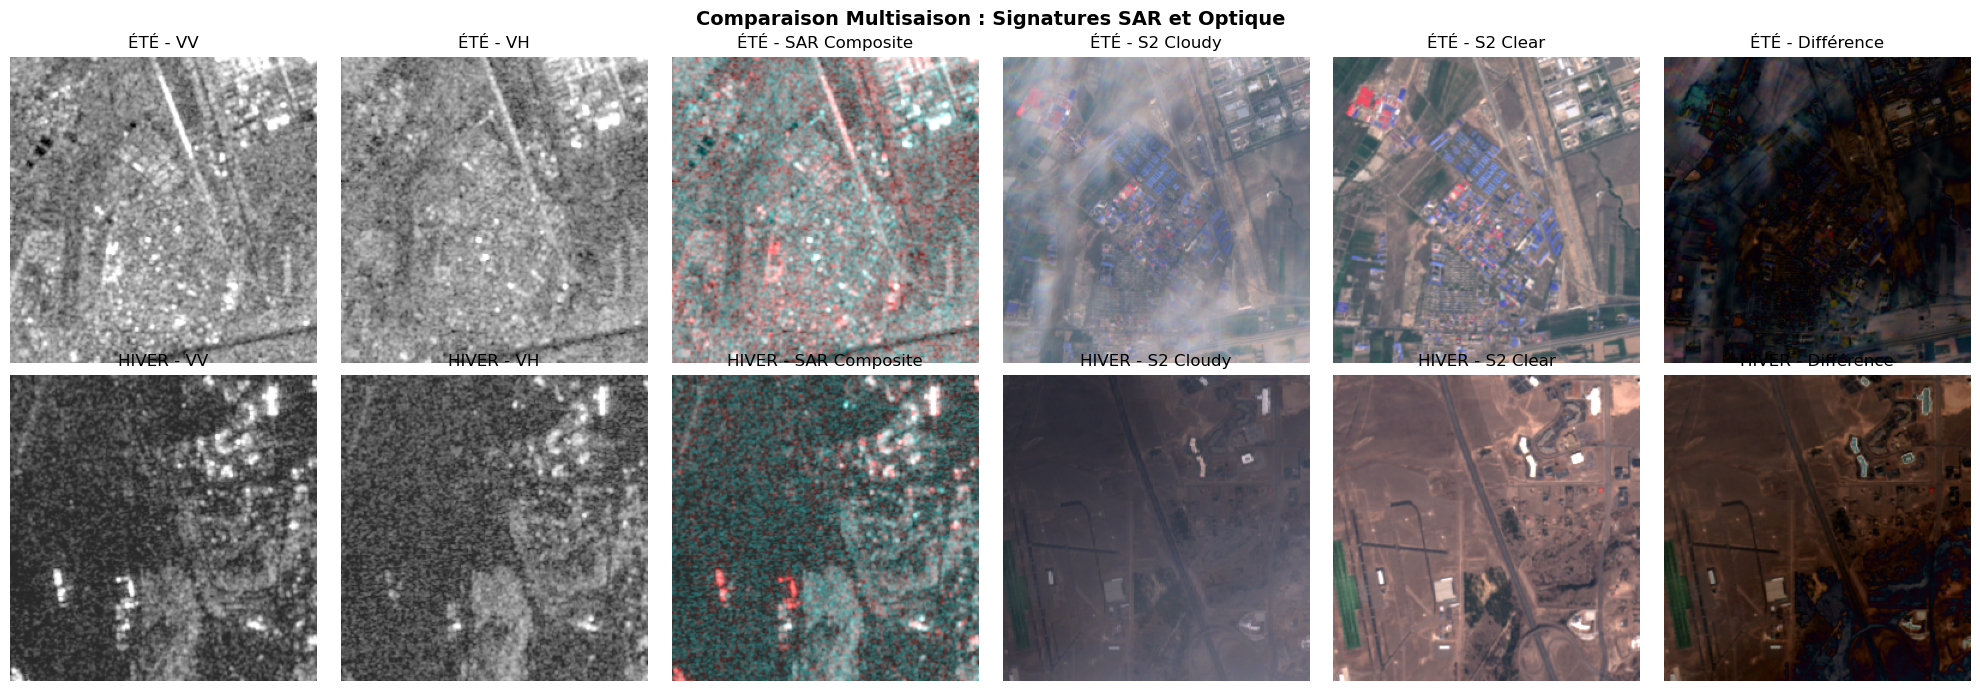


Statistiques de normalisation comparatives :

ÉTÉ (Patch summer_114_p100) :
  VV    : [-1.000, 1.000]
  VH    : [-0.852, 1.000]
  Clear : [-0.638, 1.000]
  Cloudy: [-0.439, 1.000]

HIVER (Patch winter_135_p100) :
  VV    : [-0.677, 1.000]
  VH    : [-0.670, 1.000]
  Clear : [-0.742, 1.000]
  Cloudy: [-0.738, 0.601]

Observations :
  - SAR : Signatures similaires entre saisons (normalisation adaptée)
  - Optique : Variations attendues liées aux changements de couverture
  - Validation : Pipeline de normalisation opérationnel pour multisaison


In [11]:
# Visualisation comparative été/hiver
if CSV_FILE.exists() and len(summer_triplets) > 0 and len(winter_triplets) > 0:
    
    fig, axes = plt.subplots(2, 6, figsize=(20, 7))
    
    # Fonction de chargement et visualisation
    def load_and_display(row, row_idx, season_label):
        """Charge et affiche un triplet pour une saison donnée"""
        s1_root = row.get('s1_root_folder', 'ROIs1868_summer_s1')
        s2_root = row.get('s2_root_folder', 'ROIs1868_summer_s2')
        s2_cloudy_root = row.get('s2_cloudy_root_folder', 'ROIs1868_summer_s2_cloudy')
        
        s1_path = DATA_ROOT / s1_root / row['s1_folder'] / row['s1_file']
        s2_path = DATA_ROOT / s2_root / row['s2_folder'] / row['s2_file']
        s2_cloudy_path = DATA_ROOT / s2_cloudy_root / row['s2_cloudy_folder'] / row['s2_cloudy_file']
        
        # Charger SAR
        with rasterio.open(s1_path) as src:
            vv = src.read(1)
            vh = src.read(2)
        
        vv_norm = normalize_sar_vv(vv)
        vh_norm = normalize_sar_vh(vh)
        
        # Charger Optique
        with rasterio.open(s2_path) as src:
            s2_clear = src.read([4, 3, 2])
        
        with rasterio.open(s2_cloudy_path) as src:
            s2_cloudy = src.read([4, 3, 2])
        
        # Normaliser
        clear_norm = np.stack([
            normalize_optical(s2_clear[0]),
            normalize_optical(s2_clear[1]),
            normalize_optical(s2_clear[2])
        ], axis=-1)
        
        cloudy_norm = np.stack([
            normalize_optical(s2_cloudy[0]),
            normalize_optical(s2_cloudy[1]),
            normalize_optical(s2_cloudy[2])
        ], axis=-1)
        
        # Préparer pour affichage
        vv_disp = denormalize_for_display(vv_norm)
        vh_disp = denormalize_for_display(vh_norm)
        clear_disp = denormalize_for_display(clear_norm)
        cloudy_disp = denormalize_for_display(cloudy_norm)
        sar_composite = np.stack([vv_disp, vh_disp, vh_disp], axis=-1)
        
        # Afficher
        axes[row_idx, 0].imshow(vv_disp, cmap='gray', vmin=0, vmax=1)
        axes[row_idx, 0].set_title(f'{season_label} - VV')
        axes[row_idx, 0].axis('off')
        
        axes[row_idx, 1].imshow(vh_disp, cmap='gray', vmin=0, vmax=1)
        axes[row_idx, 1].set_title(f'{season_label} - VH')
        axes[row_idx, 1].axis('off')
        
        axes[row_idx, 2].imshow(sar_composite)
        axes[row_idx, 2].set_title(f'{season_label} - SAR Composite')
        axes[row_idx, 2].axis('off')
        
        axes[row_idx, 3].imshow(cloudy_disp)
        axes[row_idx, 3].set_title(f'{season_label} - S2 Cloudy')
        axes[row_idx, 3].axis('off')
        
        axes[row_idx, 4].imshow(clear_disp)
        axes[row_idx, 4].set_title(f'{season_label} - S2 Clear')
        axes[row_idx, 4].axis('off')
        
        diff = np.abs(clear_disp - cloudy_disp)
        axes[row_idx, 5].imshow(diff)
        axes[row_idx, 5].set_title(f'{season_label} - Différence')
        axes[row_idx, 5].axis('off')
        
        # Statistiques
        return {
            'vv_range': (vv_norm.min(), vv_norm.max()),
            'vh_range': (vh_norm.min(), vh_norm.max()),
            'clear_range': (clear_norm.min(), clear_norm.max()),
            'cloudy_range': (cloudy_norm.min(), cloudy_norm.max())
        }
    
    # Charger et afficher été (ligne 0)
    summer_stats = load_and_display(summer_example, 0, 'ÉTÉ')
    
    # Charger et afficher hiver (ligne 1)
    winter_stats = load_and_display(winter_example, 1, 'HIVER')
    
    plt.suptitle("Comparaison Multisaison : Signatures SAR et Optique", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Afficher statistiques comparatives
    print(f"\nStatistiques de normalisation comparatives :")
    print(f"{'='*70}")
    print(f"\nÉTÉ (Patch {summer_example['id']}) :")
    print(f"  VV    : [{summer_stats['vv_range'][0]:.3f}, {summer_stats['vv_range'][1]:.3f}]")
    print(f"  VH    : [{summer_stats['vh_range'][0]:.3f}, {summer_stats['vh_range'][1]:.3f}]")
    print(f"  Clear : [{summer_stats['clear_range'][0]:.3f}, {summer_stats['clear_range'][1]:.3f}]")
    print(f"  Cloudy: [{summer_stats['cloudy_range'][0]:.3f}, {summer_stats['cloudy_range'][1]:.3f}]")
    
    print(f"\nHIVER (Patch {winter_example['id']}) :")
    print(f"  VV    : [{winter_stats['vv_range'][0]:.3f}, {winter_stats['vv_range'][1]:.3f}]")
    print(f"  VH    : [{winter_stats['vh_range'][0]:.3f}, {winter_stats['vh_range'][1]:.3f}]")
    print(f"  Clear : [{winter_stats['clear_range'][0]:.3f}, {winter_stats['clear_range'][1]:.3f}]")
    print(f"  Cloudy: [{winter_stats['cloudy_range'][0]:.3f}, {winter_stats['cloudy_range'][1]:.3f}]")
    
    print(f"\nObservations :")
    print(f"  - SAR : Signatures similaires entre saisons (normalisation adaptée)")
    print(f"  - Optique : Variations attendues liées aux changements de couverture")
    print(f"  - Validation : Pipeline de normalisation opérationnel pour multisaison")
elif CSV_FILE.exists() and len(winter_triplets) == 0:
    print("Visualisation comparative impossible : pas de triplets Winter dans le dataset")
    print("Le dataset actuel contient uniquement des scènes Summer.")

### 4.3 Visualisation Comparative Été vs Hiver

Comparaison visuelle des triplets représentatifs des deux saisons pour illustrer les différences de signature SAR et optique.

## 5. Architecture Pix2Pix

### 5.1 Générateur U-Net

**Architecture** : Encodeur-Décodeur avec skip connections (Ronneberger et al., 2015)

**Spécifications** :
- Entrée : 5 canaux (2 SAR + 3 RGB cloudy)
- Sortie : 3 canaux (RGB clair)
- Encodeur : 5 blocs convolutionnels avec downsampling
- Décodeur : 5 blocs transposés avec upsampling
- Skip connections : Concaténation des features de l'encodeur
- Activation finale : Tanh (sortie dans [-1, 1])

**Optimisations** :
- Pas de BatchNorm sur la première couche (préserve statistiques brutes)
- Dropout(0.5) sur les 3 premiers blocs du décodeur

In [12]:
# Importer le modèle
import sys
sys.path.append('.')
from model import UNetGenerator, PatchGANDiscriminator

# Créer le générateur
generator = UNetGenerator(in_channels=5, out_channels=3)

# Compter les paramètres
total_params = sum(p.numel() for p in generator.parameters())
trainable_params = sum(p.numel() for p in generator.parameters() if p.requires_grad)

print("Architecture U-Net Generator")
print("="*50)
print(f"  Input  : 5 canaux (VV, VH, R_cloudy, G_cloudy, B_cloudy)")
print(f"  Output : 3 canaux (R_clear, G_clear, B_clear)")
print(f"\n  Paramètres totaux      : {total_params:,}")
print(f"  Paramètres entraînables: {trainable_params:,}")
print(f"  Mémoire (float32)      : {total_params * 4 / 1024**2:.2f} MB")

# Test avec batch synthétique
test_input = torch.randn(2, 5, 256, 256)
with torch.no_grad():
    test_output = generator(test_input)

print(f"\n  Test forward pass")
print(f"    Input shape  : {test_input.shape}")
print(f"    Output shape : {test_output.shape}")
print(f"    Output range : [{test_output.min():.3f}, {test_output.max():.3f}]")

assert test_output.shape == (2, 3, 256, 256), "Erreur de dimensions"
print("\n  Vérification réussie.")

Architecture U-Net Generator
  Input  : 5 canaux (VV, VH, R_cloudy, G_cloudy, B_cloudy)
  Output : 3 canaux (R_clear, G_clear, B_clear)

  Paramètres totaux      : 16,788,867
  Paramètres entraînables: 16,788,867
  Mémoire (float32)      : 64.04 MB

  Test forward pass
    Input shape  : torch.Size([2, 5, 256, 256])
    Output shape : torch.Size([2, 3, 256, 256])
    Output range : [-0.348, 0.407]

  Vérification réussie.


### 5.2 Discriminateur PatchGAN

**Principe** : Classification locale par patchs 70×70 pixels (Isola et al., 2017)

**Architecture** :
- Entrée : 8 canaux (5 input + 3 output concatenés)
- Sortie : Grille 30×30 de classifications binaires
- 5 couches convolutionnelles avec stride=2
- Activation : LeakyReLU(0.2)
- Pas de Sigmoid final (utilisation de BCEWithLogitsLoss)

**Avantage** : Force le générateur à produire des textures localement cohérentes, réduit les artefacts.

In [13]:
# Créer le discriminateur
discriminator = PatchGANDiscriminator(in_channels=8)

# Compter les paramètres
disc_params = sum(p.numel() for p in discriminator.parameters())

print("Architecture PatchGAN Discriminator")
print("="*50)
print(f"  Input  : 8 canaux (5 input + 3 output)")
print(f"  Output : Grille 30×30 (chaque cellule = 70×70 pixels)")
print(f"\n  Paramètres totaux : {disc_params:,}")
print(f"  Mémoire (float32)  : {disc_params * 4 / 1024**2:.2f} MB")

# Test avec batch synthétique
test_input_5ch = torch.randn(2, 5, 256, 256)
test_output_3ch = torch.randn(2, 3, 256, 256)

with torch.no_grad():
    test_pred = discriminator(test_input_5ch, test_output_3ch)

print(f"\n  Test forward pass")
print(f"    Input shape  : {test_input_5ch.shape} (input)")
print(f"                   {test_output_3ch.shape} (output)")
print(f"    Pred shape   : {test_pred.shape}")
print(f"    Grille       : {test_pred.shape[2]} × {test_pred.shape[3]} patchs")

assert test_pred.shape == (2, 1, 30, 30), "Erreur de dimensions"
print("\n  Vérification réussie.")

print(f"\nArchitecture complète Pix2Pix")
print(f"  Générateur      : {total_params:,} paramètres")
print(f"  Discriminateur  : {disc_params:,} paramètres")
print(f"  TOTAL           : {total_params + disc_params:,} paramètres")

Architecture PatchGAN Discriminator
  Input  : 8 canaux (5 input + 3 output)
  Output : Grille 30×30 (chaque cellule = 70×70 pixels)

  Paramètres totaux : 2,770,753
  Mémoire (float32)  : 10.57 MB

  Test forward pass
    Input shape  : torch.Size([2, 5, 256, 256]) (input)
                   torch.Size([2, 3, 256, 256]) (output)
    Pred shape   : torch.Size([2, 1, 30, 30])
    Grille       : 30 × 30 patchs

  Vérification réussie.

Architecture complète Pix2Pix
  Générateur      : 16,788,867 paramètres
  Discriminateur  : 2,770,753 paramètres
  TOTAL           : 19,559,620 paramètres


## 6. Validation du Dataset PyTorch

Cette section vérifie que le dataset PyTorch charge correctement tous les triplets validés et applique les transformations appropriées.

In [14]:
# Recharger le module train pour avoir la dernière version
import train
importlib.reload(train)
from train import SEN12Dataset

# Créer le dataset
dataset = SEN12Dataset(
    data_folder=str(DATA_ROOT),
    csv_file=str(CSV_FILE),
    mode='csv',
    augment=False
)

print("Dataset SEN12 PyTorch")
print("="*50)
print(f"  Mode            : CSV")
print(f"  Fichier         : {CSV_FILE.name}")
print(f"  Triplets chargés: {len(dataset)}")
print(f"  Augmentation    : {dataset.augment}")

# Charger un échantillon
if len(dataset) > 0:
    input_tensor, target_tensor, patch_id = dataset[0]
    
    print(f"\nPremier échantillon (Patch {patch_id}) :")
    print(f"  Input  : {input_tensor.shape}  (5, H, W)")
    print(f"           Canal 0: S1 VV")
    print(f"           Canal 1: S1 VH")
    print(f"           Canal 2: S2 Cloudy Red")
    print(f"           Canal 3: S2 Cloudy Green")
    print(f"           Canal 4: S2 Cloudy Blue")
    print(f"  Target : {target_tensor.shape}  (3, H, W)")
    print(f"           Canal 0: S2 Clear Red")
    print(f"           Canal 1: S2 Clear Green")
    print(f"           Canal 2: S2 Clear Blue")
    print(f"\n  Ranges:")
    print(f"    Input  : [{input_tensor.min():.3f}, {input_tensor.max():.3f}]")
    print(f"    Target : [{target_tensor.min():.3f}, {target_tensor.max():.3f}]")
    
    # Vérification des plages attendues
    assert -1.1 <= input_tensor.min() <= 1.1, "Input hors plage [-1, 1]"
    assert -1.1 <= input_tensor.max() <= 1.1, "Input hors plage [-1, 1]"
    assert -1.1 <= target_tensor.min() <= 1.1, "Target hors plage [-1, 1]"
    assert -1.1 <= target_tensor.max() <= 1.1, "Target hors plage [-1, 1]"
    
    print("\n  Vérification des plages : OK")
    print("\nDataset validé et prêt pour l'entraînement.")

Dataset chargé : 4464 triplets (mode=csv)
Dataset SEN12 PyTorch
  Mode            : CSV
  Fichier         : cleaned_triplets.csv
  Triplets chargés: 4464
  Augmentation    : False

Premier échantillon (Patch summer_114_p100) :
  Input  : torch.Size([5, 256, 256])  (5, H, W)
           Canal 0: S1 VV
           Canal 1: S1 VH
           Canal 2: S2 Cloudy Red
           Canal 3: S2 Cloudy Green
           Canal 4: S2 Cloudy Blue
  Target : torch.Size([3, 256, 256])  (3, H, W)
           Canal 0: S2 Clear Red
           Canal 1: S2 Clear Green
           Canal 2: S2 Clear Blue

  Ranges:
    Input  : [-1.000, 1.000]
    Target : [-0.638, 1.000]

  Vérification des plages : OK

Dataset validé et prêt pour l'entraînement.


## 7. Test du Générateur sur Données Réelles

Passage d'un triplet réel dans le générateur (poids non entraînés) pour vérifier le pipeline complet.

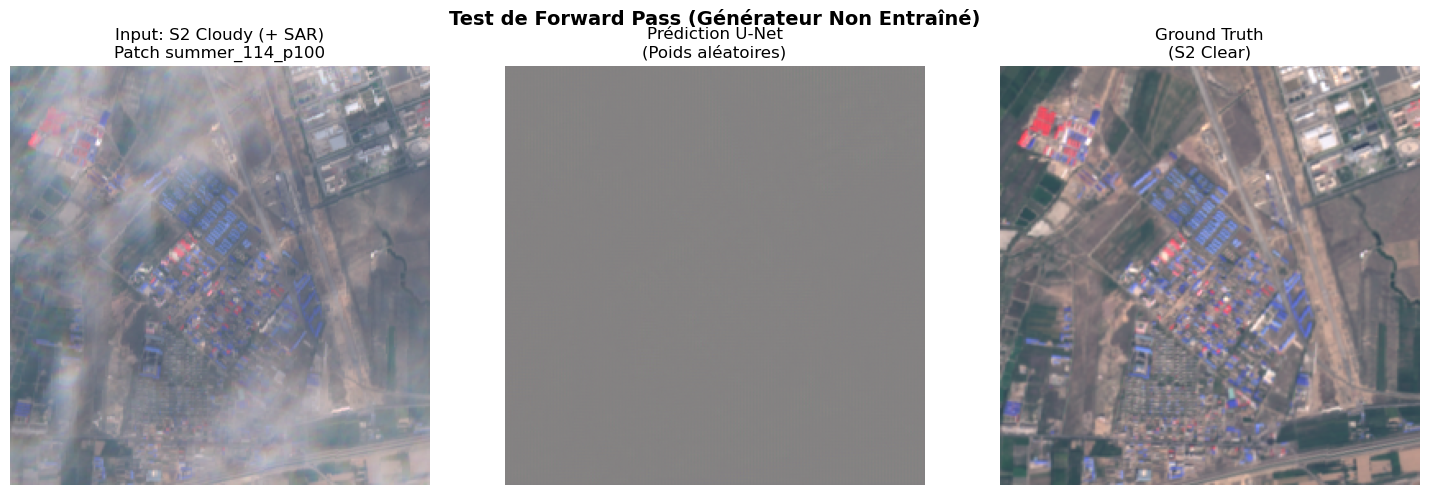

Note : Le générateur utilise des poids initialisés aléatoirement.
Après entraînement, la prédiction devrait ressembler au Ground Truth.


In [15]:
if len(dataset) > 0:
    # Charger un échantillon
    input_tensor, target_tensor, patch_id = dataset[0]
    
    # Ajouter dimension batch
    input_batch = input_tensor.unsqueeze(0)
    target_batch = target_tensor.unsqueeze(0)
    
    # Forward pass (générateur non entraîné)
    generator.eval()
    with torch.no_grad():
        prediction = generator(input_batch)
    
    # Convertir pour visualisation
    input_rgb = input_batch[0, 2:5].numpy().transpose(1, 2, 0)  # Canaux RGB de S2 Cloudy
    prediction_rgb = prediction[0].numpy().transpose(1, 2, 0)
    target_rgb = target_batch[0].numpy().transpose(1, 2, 0)
    
    input_rgb = denormalize_for_display(input_rgb)
    prediction_rgb = denormalize_for_display(prediction_rgb)
    target_rgb = denormalize_for_display(target_rgb)
    
    # Affichage
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(input_rgb)
    axes[0].set_title(f'Input: S2 Cloudy (+ SAR)\nPatch {patch_id}')
    axes[0].axis('off')
    
    axes[1].imshow(prediction_rgb)
    axes[1].set_title('Prédiction U-Net\n(Poids aléatoires)')
    axes[1].axis('off')
    
    axes[2].imshow(target_rgb)
    axes[2].set_title('Ground Truth\n(S2 Clear)')
    axes[2].axis('off')
    
    plt.suptitle("Test de Forward Pass (Générateur Non Entraîné)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("Note : Le générateur utilise des poids initialisés aléatoirement.")
    print("Après entraînement, la prédiction devrait ressembler au Ground Truth.")

## 8. Vérification de la Correspondance Géométrique

Chargement de plusieurs triplets aléatoires pour vérifier manuellement que :
1. SAR, S2 Cloudy et S2 Clear montrent la même scène
2. La différence entre Cloudy et Clear correspond bien aux nuages
3. Pas de décalage spatial entre les images

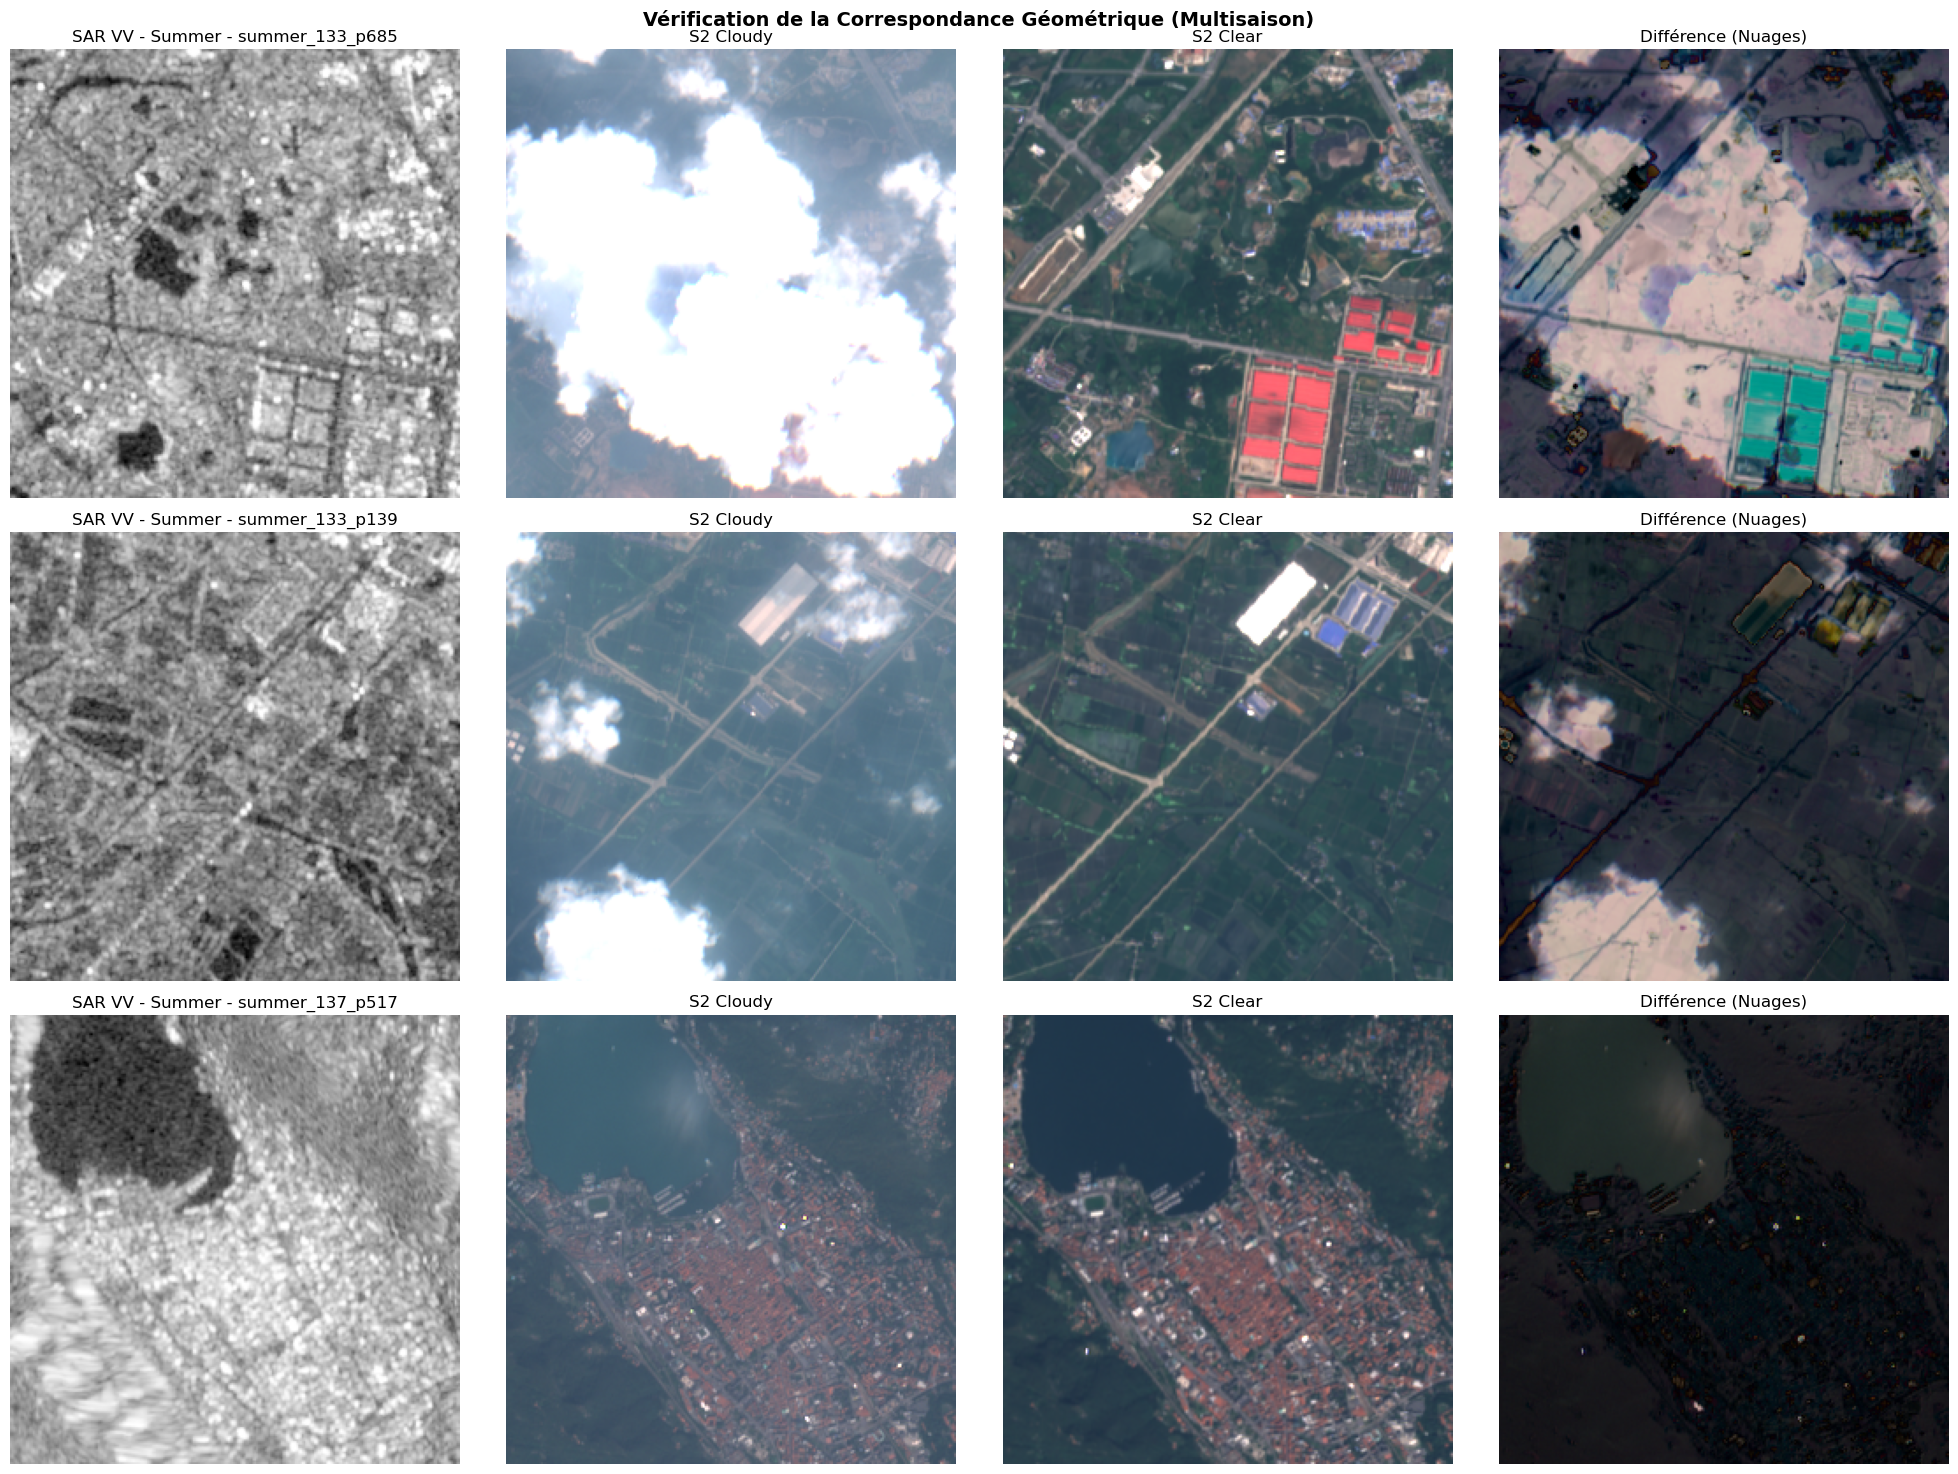


Points de vérification :
  1. SAR, Cloudy et Clear montrent-ils la même scène ?
  2. La différence (colonne 4) met-elle en évidence uniquement les nuages ?
  3. Pas de décalage spatial visible entre les images ?

Si ces 3 points sont vérifiés, le dataset est valide pour l'entraînement.


In [16]:
import random

if CSV_FILE.exists():
    df = pd.read_csv(CSV_FILE)
    n_samples = min(3, len(df))
    sample_indices = random.sample(range(len(df)), n_samples)
    
    fig, axes = plt.subplots(n_samples, 4, figsize=(20, 5 * n_samples))
    if n_samples == 1:
        axes = axes[np.newaxis, :]
    
    for idx, row_idx in enumerate(sample_indices):
        row = df.iloc[row_idx]
        patch_id = row['id']
        
        # Support multisaison
        s1_root = row.get('s1_root_folder', 'ROIs1868_summer_s1')
        s2_root = row.get('s2_root_folder', 'ROIs1868_summer_s2')
        s2_cloudy_root = row.get('s2_cloudy_root_folder', 'ROIs1868_summer_s2_cloudy')
        
        # Construire les chemins
        s1_path = DATA_ROOT / s1_root / row['s1_folder'] / row['s1_file']
        s2_path = DATA_ROOT / s2_root / row['s2_folder'] / row['s2_file']
        s2_cloudy_path = DATA_ROOT / s2_cloudy_root / row['s2_cloudy_folder'] / row['s2_cloudy_file']
        
        # Charger les images
        with rasterio.open(s1_path) as src:
            sar_vv = src.read(1)
        
        with rasterio.open(s2_path) as src:
            s2_clear = src.read([4, 3, 2])  # RGB
        
        with rasterio.open(s2_cloudy_path) as src:
            s2_cloudy = src.read([4, 3, 2])  # RGB
        
        # Normaliser pour affichage (simple linear stretch)
        sar_display = np.clip((sar_vv - sar_vv.min()) / (sar_vv.max() - sar_vv.min() + 1e-6), 0, 1)
        s2_clear_display = np.clip(s2_clear.transpose(1, 2, 0) / 3000, 0, 1)
        s2_cloudy_display = np.clip(s2_cloudy.transpose(1, 2, 0) / 3000, 0, 1)
        
        # Afficher
        season = str(patch_id).split('_')[0].capitalize() if '_' in str(patch_id) else 'Summer'
        axes[idx, 0].imshow(sar_display, cmap='gray')
        axes[idx, 0].set_title(f"SAR VV - {season} - {patch_id}")
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(s2_cloudy_display)
        axes[idx, 1].set_title("S2 Cloudy")
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(s2_clear_display)
        axes[idx, 2].set_title("S2 Clear")
        axes[idx, 2].axis('off')
        
        diff = np.abs(s2_clear_display - s2_cloudy_display)
        axes[idx, 3].imshow(diff)
        axes[idx, 3].set_title("Différence (Nuages)")
        axes[idx, 3].axis('off')
    
    plt.suptitle("Vérification de la Correspondance Géométrique (Multisaison)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nPoints de vérification :")
    print("  1. SAR, Cloudy et Clear montrent-ils la même scène ?")
    print("  2. La différence (colonne 4) met-elle en évidence uniquement les nuages ?")
    print("  3. Pas de décalage spatial visible entre les images ?")
    print("\nSi ces 3 points sont vérifiés, le dataset est valide pour l'entraînement.")

## 9. Synthèse et Prochaines Étapes

### Récapitulatif

Ce notebook a permis de valider :
1. La structure du dataset SEN12 Multisaison (Summer + Winter)
2. Les pipelines de normalisation SAR et Optique
3. L'architecture Pix2Pix (U-Net + PatchGAN)
4. Le chargement des données via PyTorch Dataset
5. La correspondance géométrique des triplets

### Configuration d'Entraînement

**Hyperparamètres** :
- Batch size : 48
- Époques : 200
- Learning rate : 0.0002
- Lambda L1 : 100
- Mixed Precision : Activée (AMP)

**Optimisation GPU** :
- RTX 3080 (10GB VRAM utilisés)
- num_workers : 8
- persistent_workers : True

### Lancement de l'Entraînement

```bash
python train.py
```

**Durée estimée (Multisaison ~8000 triplets)** :
- Batches par epoch : ~667 (8000 triplets ÷ 4 augmentations ÷ 48 batch_size)
- Temps par epoch : ~2.5 minutes
- 200 époques : **~8h20** total

**Fichiers générés** :
- `results/training_log.csv` : Métriques complètes (Loss, PSNR, SSIM)
- `results/epoch_XXX_validation.png` : Planches comparatives (SAR boosté + prédictions)
- `checkpoints/checkpoint_epoch_XXX.pth` : Checkpoints tous les 10 époques

### Analyse Post-Entraînement

Après l'entraînement, ce notebook peut être étendu pour :
1. Charger le modèle entraîné
2. Générer des prédictions sur l'ensemble de validation
3. Calculer les métriques finales (PSNR, SSIM, MAE)
4. Visualiser les courbes de convergence depuis training_log.csv
5. Identifier les meilleurs et pires cas de reconstruction
6. Comparer les performances Summer vs Winter

### Avantages du Dataset Multisaison

**Généralisation** : Le modèle apprend à reconstruire des images dans des conditions variées (végétation dense en été, sols nus en hiver).

**Robustesse** : Moins de surapprentissage sur les caractéristiques saisonnières spécifiques.

**Contraste maximal** : L'hiver offre une différence SAR/Optique plus marquée (sols nus, végétation absente).

---

**Références** :
- Isola et al. (2017). Image-to-Image Translation with Conditional Adversarial Networks. CVPR.
- Ronneberger et al. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. MICCAI.